# Comparing total hydrostatic masses measured by LoCuSS and XGA

This notebook measures hydrostatic masses for the samples we are using to verify our method, then compares them to the measurements from literature. These mass measurements include both the baryonic content of the intra-cluster medium, and that of the dark matter halo. This implicitly tests how close our measured temperature and density profiles are to those measured by the work we compare them to

The LoCuSS sample has hydrostatic mass measurements associated with them which we will compare to but the XXL-100-GC sample data is generally too shallow for such measurements.

## Import Statements

In [1]:
import pandas as pd
import numpy as np
from astropy.units import Quantity, UnitConversionError, Unit
import matplotlib.pyplot as plt
from typing import Union, List
from shutil import rmtree
import os
from tqdm import tqdm

# This adds the directory above to the path, allowing me to import the common functions that I've written in
#  common.py - this just saves me repeating boring code and makes sure its all consistent
import sys
sys.path.insert(0, '..')
from common import locuss_colour, locuss_cosmo, direct_comparison_plot, find_lims, fit_comp

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 100
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'notebooks/xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.samples import ClusterSample
from xga.sourcetools.mass import inv_abel_dens_onion_temp
from xga.models import DoubleBetaProfile1D, SimpleVikhlininDensity1D, SimpleVikhlininTemperature1D

## Reading in Sample Files and Declaring XGA ClusterSamples

This subsection involves reading in the sample files of the four test samples (described in [the sample properties notebook](sample_properties.ipynb)), then setting up separate XGA ClusterSample instances (see [the documentation](https://xga.readthedocs.io/en/latest/notebooks/tutorials/sources_samples.html) for an introduction to XGA source and sample objects.

We impose an additional cleaning step on each sample, where we make sure that (for each XMM observation initially associated with a source) at least 70% of a cluster's $R_{500}$ falls on that observation - if this requirement is not met then the observation is excluded. These requirements are set with the `clean_obs=True`, `clean_obs_reg='r500'`, and `clean_obs_threshold=0.7` arguments when a ClusterSample instance is declared.

### LoCuSS High-$L_{\rm{X}}$

The LoCuSS High-$L_{\rm{X}}$ sample was selected from ROSAT for its high luminosity clusters, and will again be a useful comparison as testing against various different analyses is beneficial in establishing the veracity of our new measurements.

In [2]:
locuss = pd.read_csv("../../sample_files/locuss_highlx_clusters.csv", dtype={'chandra_id': str, 'xmm_obsid': str})

In [3]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = locuss['ra'].values
dec = locuss['dec'].values
z = locuss['z'].values
n = locuss['name'].values
r500 = Quantity(locuss['r500'].values, 'kpc')
r2500 = Quantity(locuss['r2500'].values, 'kpc')

# Declaring the actual ClusterSample instance for the LoCuSS sample
locuss_srcs = ClusterSample(ra, dec, z, n, r500=r500, r2500=r2500, cosmology=locuss_cosmo, load_fits=True, 
                            use_peak=False, clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)

Declaring BaseSource Sample:  36%|███████████████▊                            | 18/50 [00:09<00:20,  1.56it/s]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:90: UserWarning: Source ZwCl0949.6+5207 does not appear to have any XMM data, and will not be included in the sample.
  warn("Source {n} does not appear to have any XMM data, and will not be included in the "
Declaring BaseSource Sample:  46%|████████████████████▏                       | 23/50 [00:12<00:18,  1.48it/s]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:90: UserWarning: Source Abell1423 does not appear to have any XMM data, and will not be included in the sample.
  warn("Source {n} does not appear to have any XMM data, and will not be included in the "
Declaring BaseSource Sample:  50%|██████████████████████                      | 25/50 [00:12<00:11,  2.22it/s]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:90: UserWarning: Source RXCJ1212.3-1816 does not appear to have any XMM dat

## Reading in literature data

###  Hydrostatic masses from original work

In [4]:
loc_lit_m500s = [locuss[locuss['name'] == n].iloc[0][['x_m500', 'x_m500_err', 'x_m500_err']].values
               for n in locuss_srcs.names]
loc_lit_m500s = Quantity(loc_lit_m500s, 'Msun')

loc_lit_m2500s = [locuss[locuss['name'] == n].iloc[0][['x_m2500', 'x_m2500_err', 'x_m2500_err']].values
               for n in locuss_srcs.names]
loc_lit_m2500s = Quantity(loc_lit_m2500s, 'Msun')

## Hydrostatic Mass Comparison to Literature

In [5]:
demo_sb_mod = DoubleBetaProfile1D()
demo_sb_mod.info()
demo_sb_mod.par_priors

╒═══════════════════════╤════════════════════════════════════════════════════════════════════════════╕
│ Double Beta Profile   │                                                                            │
╞═══════════════════════╪════════════════════════════════════════════════════════════════════════════╡
│ DESCRIBES             │ Surface Brightness                                                         │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ UNIT                  │ ct / (arcmin2 s)                                                           │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ PARAMETERS            │ beta_one, r_core_one, norm_one, beta_two, r_core_two, norm_two             │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS       │ , kpc, ct / (arcmin2 s), , kpc, ct / (arcmin2 s

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [1.e+00, 2.e+03] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [1.e+00, 2.e+03] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'}]

In [6]:
demo_d_mod = SimpleVikhlininDensity1D(y_unit=Unit("1 / cm^3"))
demo_d_mod.info()
demo_d_mod.par_priors

╒════════════════════════════════╤═══════════════════════════════════════════════════════════════════════╕
│ Simplified Vikhlinin Profile   │                                                                       │
╞════════════════════════════════╪═══════════════════════════════════════════════════════════════════════╡
│ DESCRIBES                      │ Gas Density                                                           │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ UNIT                           │ 1 / cm3                                                               │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ PARAMETERS                     │ beta, r_core, alpha, r_s, epsilon, norm                               │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS                │ , 

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 5.]>, 'type': 'uniform'},
 {'prior': <Quantity [ 0., 10.] 1 / cm3>, 'type': 'uniform'}]

In [7]:
demo_t_mod = SimpleVikhlininTemperature1D()
demo_t_mod.info()
demo_t_mod.par_priors

╒════════════════════════════════╤═════════════════════════════════════════════════════════════════════╕
│ Simplified Vikhlinin Profile   │                                                                     │
╞════════════════════════════════╪═════════════════════════════════════════════════════════════════════╡
│ DESCRIBES                      │ Gas Temperature                                                     │
├────────────────────────────────┼─────────────────────────────────────────────────────────────────────┤
│ UNIT                           │ keV                                                                 │
├────────────────────────────────┼─────────────────────────────────────────────────────────────────────┤
│ PARAMETERS                     │ r_cool, a_cool, t_min, t_zero, r_tran, c_power                      │
├────────────────────────────────┼─────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS                │ kpc, , keV, keV, kpc

[{'prior': <Quantity [ 10., 500.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 5.]>, 'type': 'uniform'},
 {'prior': <Quantity [0.1, 6. ] keV>, 'type': 'uniform'},
 {'prior': <Quantity [ 0.5, 15. ] keV>, 'type': 'uniform'},
 {'prior': <Quantity [100., 500.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 5.]>, 'type': 'uniform'}]

### Double Beta and Simplified Vikhlinin Density/Temperature Profiles - out to $R_{500}$, cnt$_{\rm{min}}$=3000

In [8]:
loc_sb_dblbeta_simpvikh_1_min3000_mp = inv_abel_dens_onion_temp(locuss_srcs, locuss_srcs.r500, 'double_beta', 
                                                                'simple_vikhlinin_dens', 'simple_vikhlinin_temp', 
                                                                'r500', freeze_met=False, 
                                                                temp_lo_en=Quantity(0.7, 'keV'), 
                                                                temp_hi_en=Quantity(10., 'keV'), 
                                                                temp_annulus_method='min_cnt', 
                                                                temp_min_cnt=Quantity(3000, 'ct'),
                                                                temp_use_combined=True)

Running XSPEC Fits: 100%|███████████████████████████████████████████████████████| 9/9 [00:56<00:00,  6.27s/it]
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/temperature.py:291: UserWarning: The requested annuli for ZwCl0104.4+0048 cannot be created, the data quality is too low. As such a set of four annuli will be returned
  warn("The requested annuli for {s} cannot be created, the data quality is too low. As such a set "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/temperature.py:291: UserWarning: The requested annuli for ZwCl0857.9+2107 cannot be created, the data quality is too low. As such a set of four annuli will be returned
  warn("The requested annuli for {s} cannot be created, the data quality is too low. As such a set "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/temperature.py:291: UserWarning: The requested annuli for Abell2537 cannot be created, the data quality is too low. As such a set of four annuli will be returned
  warn("The reques

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1250.58654635 1246.08790482 1737.51411708 1499.80291208 1686.99304182
 1759.05651537]


Fitting data, inverse Abel transforming, and measuring densities:   5%|▎       | 2/43 [00:51<17:49, 26.07s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [396.76596634 317.77758867 437.46500543 427.27389717 412.00830408
 441.32018411]


Fitting data, inverse Abel transforming, and measuring densities:   7%|▌       | 3/43 [01:16<16:56, 25.42s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1747.29876329  676.81911509 1935.9089884  1589.93484202 1859.27524011
 1905.17580122]


Fitting data, inverse Abel transforming, and measuring densities:   9%|▋       | 4/43 [01:38<15:42, 24.16s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 749.8880513  1970.06487777 1698.76681351 1769.20998261 1833.10100652
 1974.31274741]


Fitting data, inverse Abel transforming, and measuring densities:  12%|▉       | 5/43 [02:02<15:20, 24.23s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [498.40862254 676.91832001 321.66623507 231.58434358 459.50696112
 355.99547585]


Fitting data, inverse Abel transforming, and measuring densities:  14%|█       | 6/43 [02:27<15:02, 24.39s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [535.12038472 494.09360296 896.58739879 499.72615726 901.89381784
 900.31924374]


Fitting data, inverse Abel transforming, and measuring densities:  16%|█▎      | 7/43 [02:54<15:03, 25.10s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [270.7348263  779.99799482 642.59051098 462.54017327 622.31768877
 555.37670904]


Fitting data, inverse Abel transforming, and measuring densities:  19%|█▍      | 8/43 [03:18<14:31, 24.89s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 303.75674105  306.28539038 1942.81933534 1860.52092679 1907.74428031
 1829.34203773]


Fitting data, inverse Abel transforming, and measuring densities:  21%|█▋      | 9/43 [03:46<14:37, 25.81s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [457.82825718 446.46669932 370.5950577  356.32113517 377.20521478
 411.94185186]


Fitting data, inverse Abel transforming, and measuring densities:  28%|█▉     | 12/43 [05:06<13:40, 26.47s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [944.28429044 931.06165186 924.84856515 804.63495249 839.3584137
 926.36665309]


Fitting data, inverse Abel transforming, and measuring densities:  30%|██     | 13/43 [05:30<12:52, 25.76s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1087.99212993  678.17248394 1876.68650344 1642.58966526 1857.34672501
 1829.9592064 ]


Fitting data, inverse Abel transforming, and measuring densities:  33%|██▎    | 14/43 [05:55<12:21, 25.58s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1407.74622446  873.09290965 1425.23828058 1493.67677634 1556.62349228
 1540.68640029]


Fitting data, inverse Abel transforming, and measuring densities:  35%|██▍    | 15/43 [06:21<11:57, 25.61s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [771.39942533 794.35086437 751.68000745 832.39272355 869.29850086
 841.72178025]


Fitting data, inverse Abel transforming, and measuring densities:  37%|██▌    | 16/43 [06:46<11:28, 25.51s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1336.59177442  905.33411021 1562.19505084 1211.70062501 1380.58551053
 1561.68991588]


Fitting data, inverse Abel transforming, and measuring densities:  40%|██▊    | 17/43 [07:12<11:02, 25.49s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 596.94179652  460.42284942 1790.5455271  1377.53943058 1464.03998314
 1616.30996724]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of Abell0781's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  42%|██▉    | 18/43 [07:35<10:21, 24.84s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 474.30822269  850.16614869 2112.43582941 2496.83907056 2474.90628711
 2049.17729021]


Fitting data, inverse Abel transforming, and measuring densities:  49%|███▍   | 21/43 [08:59<09:53, 27.00s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [458.99315625 445.53617281 368.29838497 370.31670198 388.39118793
 427.96723149]


Fitting data, inverse Abel transforming, and measuring densities:  51%|███▌   | 22/43 [09:28<09:38, 27.55s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 869.36521032  243.60057364 1929.66363834 1621.8493235  1405.51391043
 1926.91250045]


Fitting data, inverse Abel transforming, and measuring densities:  56%|███▉   | 24/43 [10:16<08:11, 25.86s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 830.65229341  910.57008077 1978.03890494 1195.13929806 1499.89645471
 1949.016262  ]


Fitting data, inverse Abel transforming, and measuring densities:  60%|████▏  | 26/43 [11:11<07:29, 26.45s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 709.49346829  707.64368015 1380.39628318 1214.85962398 1045.78595269
 1123.15310043]


Fitting data, inverse Abel transforming, and measuring densities:  67%|████▋  | 29/43 [12:32<06:16, 26.86s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [866.16821818 877.08612632 806.72908871 670.93033679 737.96990643
 818.21738383]


Fitting data, inverse Abel transforming, and measuring densities:  72%|█████  | 31/43 [13:24<05:14, 26.25s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 477.84905839  811.14512362 1461.61830389 1278.52570064 1190.5978122
 1496.39247953]


Fitting data, inverse Abel transforming, and measuring densities:  77%|█████▎ | 33/43 [14:15<04:17, 25.78s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1066.30977993  853.21463962 1086.54998758 1153.98247174 1184.09812009
 1171.36836592]


Fitting data, inverse Abel transforming, and measuring densities:  93%|██████▌| 40/43 [17:24<01:18, 26.25s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1204.85739442  795.34418958 1259.58793866  987.18820865 1187.79907604
 1269.38585664]


Fitting data, inverse Abel transforming, and measuring densities:  95%|██████▋| 41/43 [17:50<00:52, 26.22s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [440.0800216  453.15047977 479.82626837 265.21513607 344.97387967
 483.06720162]


Fitting data, inverse Abel transforming, and measuring densities:  98%|██████▊| 42/43 [18:14<00:25, 25.52s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 920.34696179  890.05977039 1329.68875264 1402.5402858  1291.82515926
 1314.30971249]


Fitting data, inverse Abel transforming, and measuring densities: 100%|███████| 43/43 [18:37<00:00, 25.98s/it]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 799.71605121  480.93124253 2020.79010752 1919.49081154 1673.26829344
 1954.99991275]


Generating Abell2697 hydrostatic mass profile:   0%|                                   | 0/45 [00:00<?, ?it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [607.36960182 908.12731356 416.96028116 809.72830931 324.25484583
 334.34077792]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [109.62099991 162.67747053 989.54704609 114.60527087 107.71333108
 489.36031939]


Generating Abell0068 hydrostatic mass profile:   2%|▌                          | 1/45 [00:47<34:55, 47.62s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [387.7090716  609.98544507 255.96595034 629.49242901 310.9487222
 253.25563147]


Generating Abell2813 hydrostatic mass profile:   4%|█▏                         | 2/45 [01:38<35:27, 49.47s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [214.19034549 342.93238219 687.29341649 139.03311386 189.94948904
 453.14760505]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [387.56418349 754.27100475 372.55149991 454.76236227 262.98007809
 244.00817887]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 109.44782263  174.93546217 1318.54005265  113.10724079  104.87748088
  730.56408744]


Generating Abell0115S hydrostatic mass profile:   7%|█▋                        | 3/45 [02:26<34:02, 48.64s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [779.1644188  811.0483588  888.96921486 590.19013671 276.50621248
 880.52943319]


Generating Abell141 hydrostatic mass profile:   9%|██▍                         | 4/45 [03:12<32:42, 47.85s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [105.19995272 179.67893445 530.21157611 103.7684504  134.6926702
 179.70881947]


Generating Abell0209 hydrostatic mass profile:  13%|███▌                       | 6/45 [04:45<30:34, 47.03s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [211.07123265 147.84133897 382.37936045 437.44678393 325.19462874
 124.12060657]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [397.00795624 454.05697468 653.94988551 298.18825297 375.79803456
 483.13349089]


Generating Abell0267 hydrostatic mass profile:  16%|████▏                      | 7/45 [05:37<30:40, 48.42s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [362.23268107 369.69690421 466.92352377 309.7996204  218.69453753
 287.37682532]


Generating Abell0291 hydrostatic mass profile:  18%|████▊                      | 8/45 [06:25<29:46, 48.28s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 95.64315242 100.28068249 782.54548465  97.77583034 120.3534611
 106.17364171]


Generating Abell0383 hydrostatic mass profile:  20%|█████▍                     | 9/45 [07:15<29:15, 48.76s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [733.17338078 847.34186153 467.37134624 592.29369526 394.97969782
 442.3430912 ]


Generating Abell0521 hydrostatic mass profile:  22%|█████▊                    | 10/45 [08:06<28:56, 49.60s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 80.46070475  84.19653072 972.60082803  95.75235344  94.55489033
  86.19167972]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [341.6773475  469.0836895  386.31037254 471.99524128 309.36616565
 249.12353665]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1522.25196127 1476.94871765 1133.19160834 1195.41101957 1444.44998219
 1135.19639209]


Generating Abell0586 hydrostatic mass profile:  24%|██████▎                   | 11/45 [08:54<27:46, 49.02s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 448.87652964  668.54896912 1008.65074642  335.30750907  304.12512148
  390.53162527]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 98.00521703 101.6136606  432.68522872 106.75739832 133.47029963
 102.2010761 ]


Generating Abell0611 hydrostatic mass profile:  27%|██████▉                   | 12/45 [09:43<27:03, 49.19s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [350.22940667 883.44055333 609.94145287 615.0053142  379.77522959
 361.95276314]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 146.01511728  174.25019437 1094.81219713  132.26731454  118.94048604
  203.98731847]


Generating Abell0697 hydrostatic mass profile:  29%|███████▌                  | 13/45 [10:30<25:54, 48.56s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 472.13497961 1060.43725288  337.53209349  951.59187015  334.04948904
  288.43622271]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 114.29872238  193.55358869 1343.88806068  105.86506977  108.88480589
  919.59649051]


Generating ZwCl0857.9+2107 hydrostatic mass profile:  31%|██████▏             | 14/45 [11:19<25:04, 48.54s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 721.3892883  1849.80106858  865.33155388 1201.5529923   500.25346353
 1194.83601326]


Generating Abell0750 hydrostatic mass profile:  33%|████████▋                 | 15/45 [12:06<24:05, 48.17s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [  88.38530716  103.83991296 1010.58591467   91.77286655   92.22410117
  103.59094258]
The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 488.63416282 1210.70547158 1464.49765222  435.60949288  276.74005517
  425.66874905]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1817.14747568 2037.83590545 2199.38440044 1496.99407605 1205.14765813
 2177.02439541]


Generating Abell0773 hydrostatic mass profile:  36%|█████████▏                | 16/45 [12:57<23:36, 48.83s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [601.80755868 843.44082113 382.09106047 745.33309855 355.55032992
 293.82836444]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [  90.0605188    92.79917377 1061.84786914  103.92687549  120.79086926
   99.18761808]


Generating Abell0781 hydrostatic mass profile:  38%|█████████▊                | 17/45 [13:44<22:39, 48.54s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/mass.py:240: UserWarning: The density profile for Abell0781 could not be generated
  warn("The density profile for {} could not be generated".format(src.name))
Generating Abell0901 hydrostatic mass profile:  40%|██████████▍               | 18/45 [13:44<21:50, 48.54s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [512.94183889 577.48505599 423.89803617 569.00053613 365.67437228
 403.81570416]


Generating Abell0907 hydrostatic mass profile:  42%|██████████▉               | 19/45 [14:36<16:26, 37.94s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [  77.02529677   78.73156241 1148.1105084    79.04028963   80.19374643
   81.98081387]


Generating Abell0963 hydrostatic mass profile:  44%|███████████▌              | 20/45 [15:28<17:20, 41.64s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [331.35403447 477.84710338 662.87454131 380.65158788 317.37887681
 302.23174698]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [102.85883418 108.8757366  713.3063324   99.34528242 115.14574352
 109.58666753]


Generating ZwCl1021.0+0426 hydrostatic mass profile:  47%|█████████▎          | 21/45 [16:16<17:16, 43.19s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 912.10845519 1144.79221551  754.76156777  839.35694796  472.52209098
  636.12556264]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 73.35075673  82.00681094 593.98671416  77.94084718 133.49328859
  64.11064434]


Generating Abell1451 hydrostatic mass profile:  49%|████████████▋             | 22/45 [17:05<17:09, 44.76s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [450.95774284 765.52443745 298.8272847  553.16306194 322.72485708
 258.18789575]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [  92.91108076   97.23775005 1244.19588927   96.36398557  142.39666454
  154.07039612]


Generating ZwCl1231.4+1007 hydrostatic mass profile:  51%|██████████▏         | 23/45 [17:54<16:51, 45.97s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/mass.py:234: UserWarning: A mass of less than zero was measured by a hydrostatic mass profile, this is not physical and the profile is not valid.
  warn("A mass of less than zero was measured by a hydrostatic mass profile, this is not physical"
Generating Abell1689 hydrostatic mass profile:  53%|█████████████▊            | 24/45 [18:43<16:24, 46.90s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [491.00164069 482.88228369 203.99325286 460.59072807 362.94766241
 253.85326811]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 78.8042591   84.65223848 684.1988787   79.65773398  82.82721878
  88.92225382]


Generating Abell1763 hydrostatic mass profile:  58%|███████████████           | 26/45 [19:37<15:27, 48.80s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [537.84816612 972.57199401 333.28324962 766.44747784 362.35923966
 398.37835226]


Generating Abell1835 hydrostatic mass profile:  60%|███████████████▌          | 27/45 [20:25<11:16, 37.59s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 94.03550339  96.9708434  680.52346695 103.71080554 110.35519995
  99.44928685]
The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [773.57341045 811.63067818 633.19869357 942.54644384 300.26734437
 801.16322336]


Generating Abell1914 hydrostatic mass profile:  62%|████████████████▏         | 28/45 [21:18<11:43, 41.40s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 833.53746614 1283.50880284  333.81410652 1341.10577258  529.36160174
  371.25385935]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [199.44016397 915.61464118 703.16124294 219.679819   221.59285133
 252.18542133]


Generating ZwCl1454.8+2233 hydrostatic mass profile:  64%|████████████▉       | 29/45 [22:06<11:28, 43.03s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [468.69189866 651.71195749 779.58277195 444.53332508 371.91235162
 380.09383909]


Generating Abell2009 hydrostatic mass profile:  67%|█████████████████▎        | 30/45 [22:54<11:05, 44.39s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [  96.05846513   96.70407045 1223.21494227  113.88867028  152.69237578
   97.30632521]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [384.3720121  506.61723018 618.083166   342.47626427 221.46626936
 204.82576284]


Generating ZwCl1459.4+4240 hydrostatic mass profile:  69%|█████████████▊      | 31/45 [23:49<11:03, 47.42s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 405.01040679  500.79271568  361.88743832  852.65815294  307.79749344
 1081.1062777 ]


Generating RXCJ1504.1-0248 hydrostatic mass profile:  71%|██████████████▏     | 32/45 [24:36<10:14, 47.25s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1967.19484299 2082.01815094 2008.63564403  633.86830054 1977.69447789
 1548.56600174]
The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 820.66836456 1073.61511255  275.12873813  839.2538194   522.04322135
  747.96500904]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 62.59696541  71.58304419 906.78332709  85.61675037  82.9654094
  38.2737537 ]


Generating Abell2111 hydrostatic mass profile:  73%|███████████████████       | 33/45 [25:30<09:50, 49.23s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 362.27489853  364.98573367  349.33039047  737.18744816  308.03209603
 2002.90303852]


Generating Abell2204 hydrostatic mass profile:  76%|███████████████████▋      | 34/45 [26:19<09:01, 49.22s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 425.11225846  871.381351   1089.0429112   265.17383601  177.88630379
 1014.13549335]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 80.69420448  76.74305672 612.74407134  82.56807349  86.71749541
  68.97931032]


Generating RXJ1720.1+2638 hydrostatic mass profile:  80%|████████████████▊    | 36/45 [27:18<07:48, 52.02s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [556.51794806 477.50698117 163.37928064 567.91636522 226.56005742
 474.55672029]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 72.02627482  70.96786543 636.93646843  72.16668305  73.39970278
  64.08691141]


Generating Abell2261 hydrostatic mass profile:  82%|█████████████████████▍    | 37/45 [28:12<05:25, 40.68s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 86.64207518  92.19482019 781.35401449  81.31908404  87.22350098
  99.04399578]


Generating RXJ2129.6+0005 hydrostatic mass profile:  87%|██████████████████▏  | 39/45 [29:52<04:27, 44.58s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [532.50111089 621.87087337 860.94726883 542.82004203 431.69004066
 394.49257559]


Generating Abell2390 hydrostatic mass profile:  89%|███████████████████████   | 40/45 [30:42<03:51, 46.20s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 78.1138108   81.06373292 593.08062406  84.17472056  81.76211137
  89.98324304]


Generating Abell2537 hydrostatic mass profile:  91%|███████████████████████▋  | 41/45 [31:35<03:11, 47.94s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [306.29301464 431.61784636 414.67224822 310.8573462  246.06909528
 254.85537459]


Generating Abell2552 hydrostatic mass profile:  93%|████████████████████████▎ | 42/45 [32:23<02:24, 48.13s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 493.56898608  786.23819709 1270.33296758  300.25706135  186.44306284
  921.67375426]


Generating Abell2631 hydrostatic mass profile:  96%|████████████████████████▊ | 43/45 [33:12<01:36, 48.47s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [670.28265039 729.38954356 320.19124377 726.37397325 346.62293187
 319.35850821]


Generating Abell2645 hydrostatic mass profile:  98%|█████████████████████████▍| 44/45 [34:00<00:48, 48.33s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [437.8172792  576.07114872 357.56648505 509.55703747 301.21915546
 271.64830014]


Complete: 100%|███████████████████████████████████████████████████████████████| 45/45 [34:48<00:00, 46.41s/it]


In [9]:
loc_sb_dblbeta_simpvikh_1_mc3000_m500 = []
loc_sb_dblbeta_simpvikh_1_mc3000_m2500 = []

with tqdm(desc='Measuring Masses for LoCuSS Clusters', total=len(loc_sb_dblbeta_simpvikh_1_min3000_mp)) as onwards:
    for mp in loc_sb_dblbeta_simpvikh_1_min3000_mp:
        if mp is not None:
            rel_src = locuss_srcs[mp.src_name]
            m = mp.mass(rel_src.r500)[0]
            if m[0] < Quantity(1e+13, 'Msun'):
                m = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
                m2500 = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
            else:
                m2500 = mp.mass(rel_src.r2500)[0]
        else:
            m = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
            m2500 = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
            
        loc_sb_dblbeta_simpvikh_1_mc3000_m500.append(m)
        loc_sb_dblbeta_simpvikh_1_mc3000_m2500.append(m2500)
        
        onwards.update(1)

loc_sb_dblbeta_simpvikh_1_mc3000_m500 = Quantity(loc_sb_dblbeta_simpvikh_1_mc3000_m500)
loc_sb_dblbeta_simpvikh_1_mc3000_m2500 = Quantity(loc_sb_dblbeta_simpvikh_1_mc3000_m2500)

Measuring Masses for LoCuSS Clusters: 100%|███████████████████████████████████| 45/45 [00:01<00:00, 42.43it/s]


In [10]:
print("{s} out of {t} R2500 mass measurements produced a "\
      "result".format(s=np.isfinite(loc_sb_dblbeta_simpvikh_1_mc3000_m2500[:, 0]).sum(), 
                      t=len(loc_sb_dblbeta_simpvikh_1_mc3000_m2500)))
print("{s} out of {t} R500 mass measurements produced a "\
      "result".format(s=np.isfinite(loc_sb_dblbeta_simpvikh_1_mc3000_m500[:, 0]).sum(), 
                      t=len(loc_sb_dblbeta_simpvikh_1_mc3000_m500)))

41 out of 45 R2500 mass measurements produced a result
41 out of 45 R500 mass measurements produced a result


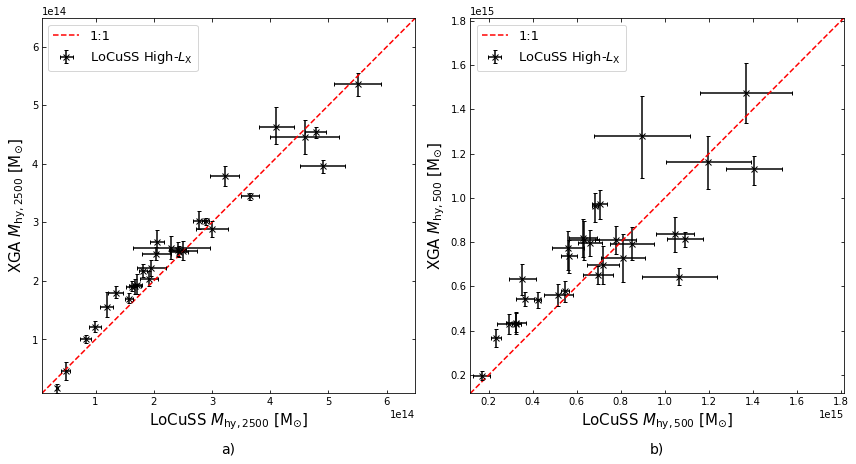

In [11]:
direct_comparison_plot([loc_lit_m2500s, loc_lit_m500s], 
                       [loc_sb_dblbeta_simpvikh_1_mc3000_m2500, loc_sb_dblbeta_simpvikh_1_mc3000_m500], 
                       [r"LoCuSS $M_{\rm{hy, 2500}}$ [M$_{\odot}$]", r"LoCuSS $M_{\rm{hy, 500}}$ [M$_{\odot}$]"], 
                       [r"XGA $M_{\rm{hy, 2500}}$ [M$_{\odot}$]", r"XGA $M_{\rm{hy, 500}}$ [M$_{\odot}$]"],
                       r"LoCuSS High-$L_{\rm{X}}$", (12, 6.5), ['linear', 'linear'], ['linear', 'linear'], 
                       savepath='../../outputs/figures/loc_sb_dblbeta_simpvikh_1r500_mc3000_hymcomp.pdf')